In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['text.color'] = '#FF1493'
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG19

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_lung = '/content/drive/MyDrive/Lung_Cancer'

In [ ]:
ldis_typ = ['Bengin cases','Malignant cases','Normal cases']
trdr = os.path.join(dir_lung)

In [ ]:
dirs=os.listdir(dir_lung)
tot=0
for i in dirs:
    ldr=os.path.join(dir_lung ,i)
    print("Total Available Images in {} ==> {}.".format(i,len(os.listdir(ldr))))
    tot+=len(os.listdir(ldr))
print("\nCount of Images: ",tot)

Total Available Images in Malignant cases ==> 561.
Total Available Images in Normal cases ==> 416.
Total Available Images in Bengin cases ==> 120.

Count of Images:  1097


In [ ]:
data_to_train = []
for defects_id, sp in enumerate(ldis_typ):
    for file in os.listdir(os.path.join(trdr, sp)):
        data_to_train.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(data_to_train, columns=['File', 'DsID','Type'])
train.tail()

,File,DsID,Type
1092,Normal cases/Normal case (96).jpg,2,Normal cases
1093,Normal cases/Normal case (92).jpg,2,Normal cases
1094,Normal cases/Normal case (88).jpg,2,Normal cases
1095,Normal cases/Normal case (93).jpg,2,Normal cases
1096,Normal cases/Normal case (95).jpg,2,Normal cases


In [ ]:
train = train.sample(frac=1, random_state=42) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DsID,Type
0,Bengin cases/Bengin case (92).jpg,0,Bengin cases
1,Malignant cases/Malignant case (454).jpg,1,Malignant cases
2,Bengin cases/Bengin case (49).jpg,0,Bengin cases
3,Malignant cases/Malignant case (536).jpg,1,Malignant cases
4,Malignant cases/Malignant case (361).jpg,1,Malignant cases


In [ ]:
lubg_dstyp=train['Type'].value_counts().index.tolist()
print(lubg_dstyp)
cnt=train['Type'].value_counts().tolist()
dssdf=pd.DataFrame({"Type":lubg_dstyp,"Count":cnt})
fig = px.bar(dssdf, y="Type", x="Count",
             text="Count",color="Type",
             title="Count of Labels in Databse",height=500,width=800)
fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="dodgerblue"
        )
    )
fig.show()


['Malignant cases', 'Normal cases', 'Bengin cases']


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
			Showing Images belongs to Benign Cases
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


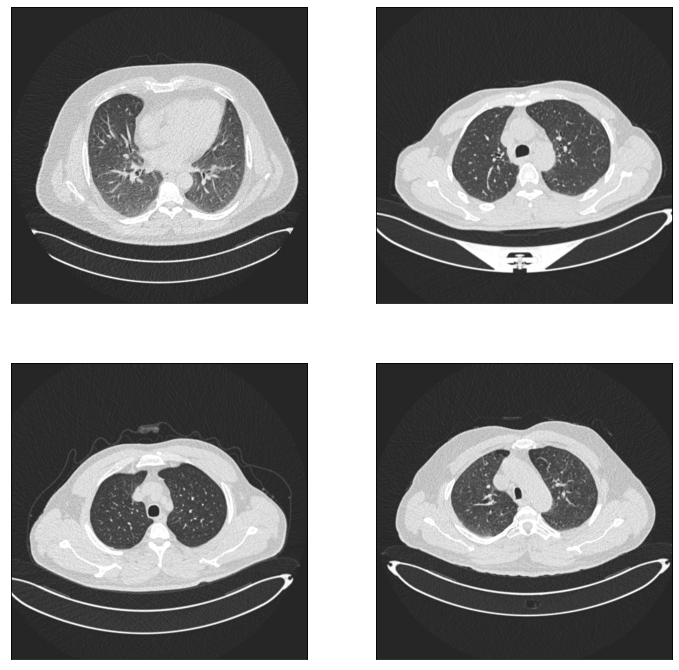

In [ ]:
def func_disease(typ_ds, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Type'] == typ_ds].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(dir_lung, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("\t\t\tShowing Images belongs to Benign Cases")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
func_disease('Bengin cases', 2,2)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
			Showing Images belong to Malignant cases
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


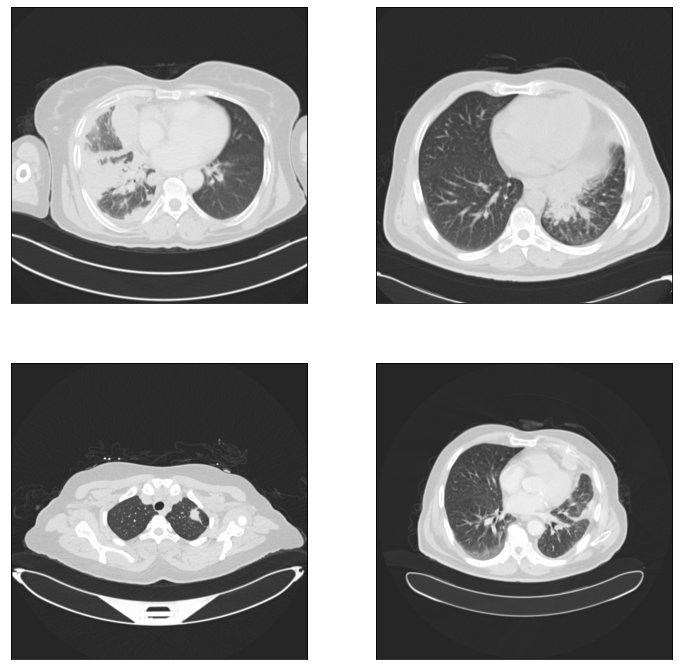

In [ ]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("\t\t\tShowing Images belong to Malignant cases")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
func_disease('Malignant cases',2,2)

In [ ]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train))
train.head()

,File,DsID,Type
0,Malignant cases/Malignant case (374).jpg,1,Malignant cases
1,Normal cases/Normal case (123).jpg,2,Normal cases
2,Malignant cases/Malignant case (177).jpg,1,Malignant cases
3,Normal cases/Normal case (53).jpg,2,Normal cases
4,Bengin cases/Bengin case (26).jpg,0,Bengin cases


In [ ]:
IMAGE_SIZE = 64

def read_image(path):
    return cv2.imread(os.path.join(dir_lung, path))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

1097it [12:50,  1.42it/s]

Train Shape: (1097, 64, 64, 3)


In [ ]:
Y_train = train['DsID'].values
Y_train = to_categorical(Y_train, num_classes=7)

In [ ]:
BATCH_SIZE = 64
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        vertical_flip=True)

datagen.fit(X_train)

In [ ]:
EPOCHS = 200
SIZE=64
N_ch=3

In [ ]:
def model_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    d121 = Conv2D(3, (3, 3), padding='same')(input)
    d121 = densenet(d121)
    d121 = GlobalAveragePooling2D()(d121)
    d121 = BatchNormalization()(d121)
    d121 = Dropout(0.5)(d121)
    d121 = Dense(256, activation='relu')(d121)
    d121 = BatchNormalization()(d121)
    d121 = Dropout(0.5)(d121)
    output = Dense(7,activation = 'softmax', name='root')(d121)
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
modelden = model_densenet()
histden = modelden.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0   

In [ ]:
allacc,allprec,allrecall,allf1,tracc,trlss=[],[],[],[],[],[]

In [ ]:
final_lossden, final_accuracyden = modelden.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}%'.format(final_lossden, round(final_accuracyden,3)*100))
tracc.append(round(final_lossden,3))
trlss.append(round(final_accuracyden,3)*100)

7/7 [==============================] - 0s 19ms/step - loss: 0.2967 - accuracy: 0.9091
Final Loss: 0.29673147201538086, Final Accuracy: 90.9%


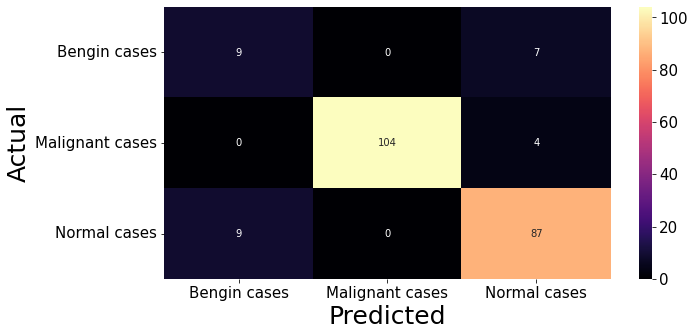

In [ ]:
Y_pred = modelden.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,5))
ax = sns.heatmap(cm, fmt="d",annot=True,cmap="magma", xticklabels=ldis_typ, yticklabels=ldis_typ)
ax.set_ylabel('Actual', fontsize=25)
ax.set_xlabel('Predicted', fontsize=25)
plt.show()
allacc.append(round(accuracy_score(Y_true,Y_pred),2)*100)
allprec.append(round(precision_score(Y_true,Y_pred,average="weighted"),2)*100)
allrecall.append(round(recall_score(Y_true,Y_pred,average="weighted"),2)*100)
allf1.append(round(f1_score(Y_true,Y_pred,average="weighted"),2)*100)

In [ ]:
model_stat_den=pd.DataFrame({
    "Epoch":[i+1 for i in range(EPOCHS)],
    "Training Loss":histden.history['loss'],
    "Test Loss":histden.history['val_loss'],
    "Training Accuracy":histden.history['accuracy'],
    "Test Accuracy":histden.history['val_accuracy']
})
model_stat_den.to_csv("outcome_densenet.csv")
model_stat_den

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,3.217613,2.514304,0.134071,0.213636
1,2,3.091867,2.509606,0.161132,0.118182
2,3,2.894004,2.209538,0.167282,0.218182
3,4,2.799680,2.377754,0.194342,0.100000
4,5,2.619510,2.648843,0.238622,0.040909
...,...,...,...,...,...
195,196,0.187775,0.841214,0.924969,0.740909
196,197,0.179559,0.678842,0.937269,0.813636
197,198,0.201004,0.690758,0.933579,0.840909
198,199,0.199499,0.359195,0.922509,0.909091


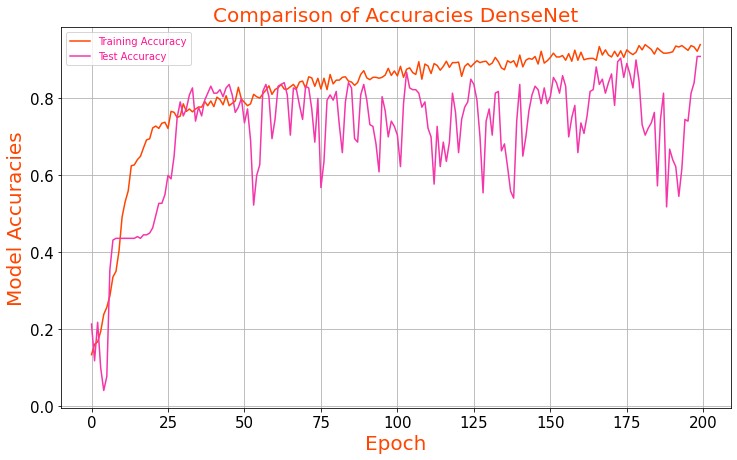

In [ ]:
collist=["#FF4500","#F535AA"]
model_stat_den.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies DenseNet",fontsize=20,color=collist[0])
plt.xlabel("Epoch",fontsize=20,color=collist[0])
plt.ylabel("Model Accuracies",fontsize=20,color=collist[0])
plt.grid()
plt.show()

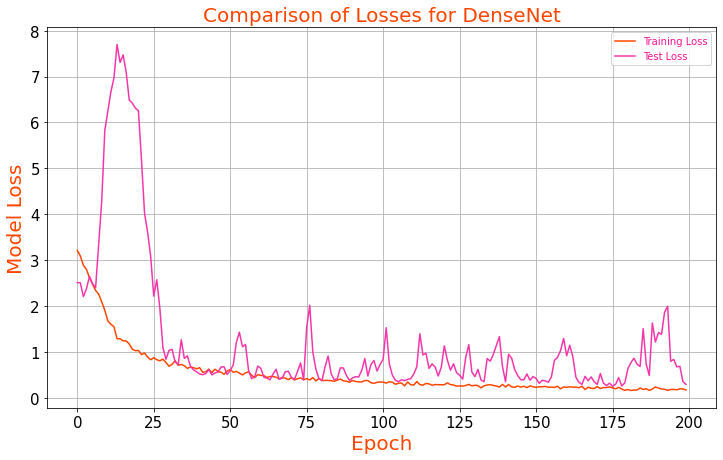

In [ ]:
model_stat_den.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for DenseNet",fontsize=20,color=collist[0])
plt.xlabel("Epoch",fontsize=20,color=collist[0])
plt.ylabel("Model Loss",fontsize=20,color=collist[0])
plt.grid()
plt.show()

In [ ]:
def model_resnet():
    resnet = ResNet50(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    res = Conv2D(3, (3, 3), padding='same')(input)
    res = resnet(res)
    res = GlobalAveragePooling2D()(res)
    res = BatchNormalization()(res)
    res = Dropout(0.5)(res)
    res = Dense(256, activation='relu')(res)
    res = BatchNormalization()(res)
    res = Dropout(0.5)(res)
    output = Dense(7,activation = 'softmax', name='root')(res)
    modelres = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    modelres.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    modelres.summary()
    
    return modelres

In [ ]:
modelres = model_resnet()
checkpointres = ModelCheckpoint('modelres.h5', verbose=1, save_best_only=True)
histres = modelres.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpointres],
               validation_data=(X_val, Y_val))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_10 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0   

In [ ]:
final_lossres, final_accuracyres = modelres.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}%'.format(final_lossres, round(final_accuracyres,3)*100))
tracc.append(round(final_lossres,3))
trlss.append(round(final_accuracyres,3)*100)

7/7 [==============================] - 0s 19ms/step - loss: 0.6777 - accuracy: 0.8091
Final Loss: 0.6777052283287048, Final Accuracy: 80.9%


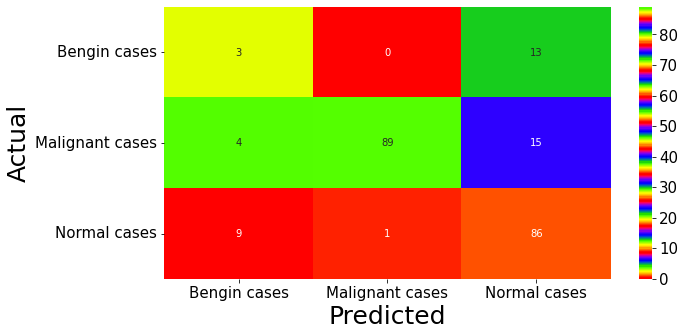

In [ ]:
Y_pred = modelres.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cmres = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,5))
ax = sns.heatmap(cmres, fmt="d",annot=True,cmap="prism", xticklabels=ldis_typ, yticklabels=ldis_typ)
ax.set_ylabel('Actual', fontsize=25)
ax.set_xlabel('Predicted', fontsize=25)
plt.show()

allacc.append(round(accuracy_score(Y_true,Y_pred),2)*100)
allprec.append(round(precision_score(Y_true,Y_pred,average="weighted"),2)*100)
allrecall.append(round(recall_score(Y_true,Y_pred,average="weighted"),2)*100)
allf1.append(round(f1_score(Y_true,Y_pred,average="weighted"),2)*100)

In [ ]:
model_stat_res=pd.DataFrame({
    "Epoch":[i+1 for i in range(EPOCHS)],
    "Training Loss":histres.history['loss'],
    "Test Loss":histres.history['val_loss'],
    "Training Accuracy":histres.history['accuracy'],
    "Test Accuracy":histres.history['val_accuracy']
})
model_stat_res.to_csv("outcome_resnet.csv")
model_stat_res

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,3.177526,2.233686,0.143911,0.490909
1,2,2.925784,1.994913,0.196802,0.468182
2,3,2.758816,1.867899,0.201722,0.381818
3,4,2.739096,1.906492,0.186962,0.490909
4,5,2.435828,3.003733,0.246002,0.490909
...,...,...,...,...,...
195,196,0.249198,3.463431,0.902644,0.395455
196,197,0.278868,0.561023,0.889299,0.795455
197,198,0.235245,0.530833,0.896679,0.800000
198,199,0.259000,0.464780,0.908979,0.818182


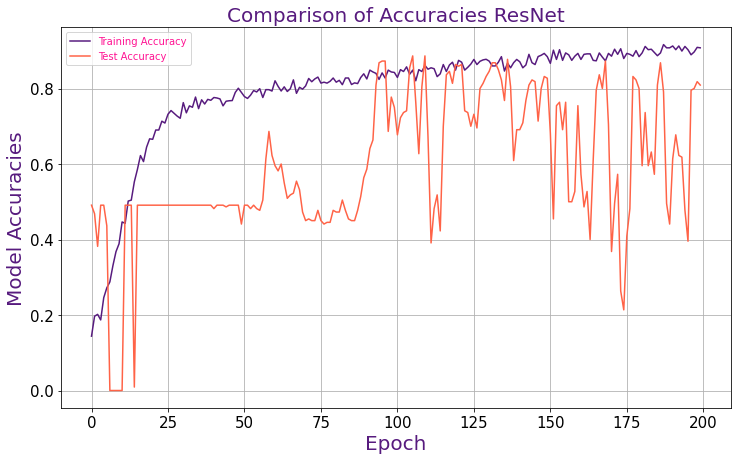

In [ ]:
collist1=["#571B7E","#FF6347"]
model_stat_res.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist1)
plt.title("Comparison of Accuracies ResNet",fontsize=20,color=collist1[0])
plt.xlabel("Epoch",fontsize=20,color=collist1[0])
plt.ylabel("Model Accuracies",fontsize=20,color=collist1[0])
plt.grid()
plt.show()

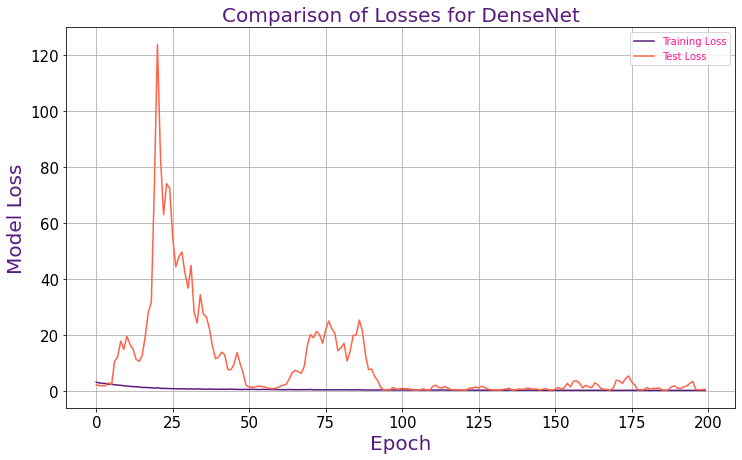

In [ ]:
model_stat_res.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist1)
plt.title("Comparison of Losses for DenseNet",fontsize=20,color=collist1[0])
plt.xlabel("Epoch",fontsize=20,color=collist1[0])
plt.ylabel("Model Loss",fontsize=20,color=collist1[0])
plt.grid()
plt.show()

In [ ]:
def model_cnn():
    cnn = Sequential()

    input = Input(shape=(SIZE, SIZE, N_ch))
    cnnlyr = Conv2D(3, (3, 3), padding='same')(input)
    cnnlyr = cnn(cnnlyr)
    cnnlyr = GlobalAveragePooling2D()(cnnlyr)
    cnnlyr = BatchNormalization()(cnnlyr)
    cnnlyr = Dropout(0.5)(cnnlyr)
    cnnlyr = Dense(256, activation='relu')(cnnlyr)
    cnnlyr = BatchNormalization()(cnnlyr)
    cnnlyr = Dropout(0.5)(cnnlyr)
    output = Dense(7,activation = 'softmax', name='root')(cnnlyr)
    modelcnn = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    modelcnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    modelcnn.summary()
    
    return modelcnn

In [ ]:
modelcnn = model_cnn()
checkpointcnn = ModelCheckpoint('modelcnn.h5', verbose=1, save_best_only=True)
histcnn = modelcnn.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 global_average_pooling2d_6   (None, 3)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 3)                12        
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 3)                 0   

In [ ]:
final_losscnn, final_accuracycnn = modelcnn.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}%'.format(final_losscnn, round(final_accuracycnn,3)*100))
tracc.append(round(final_losscnn,3))
trlss.append(round(final_accuracycnn,3)*100)

7/7 [==============================] - 0s 3ms/step - loss: 1.1482 - accuracy: 0.4909
Final Loss: 1.1482055187225342, Final Accuracy: 49.1%


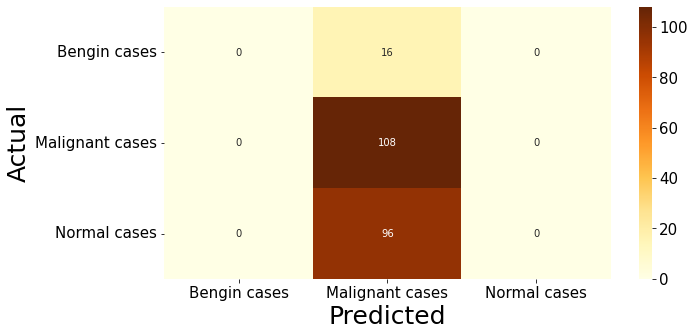

In [ ]:
Y_pred = modelcnn.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cmcnn = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10,5))
ax = sns.heatmap(cmcnn, fmt="d",annot=True,cmap="YlOrBr", xticklabels=ldis_typ, yticklabels=ldis_typ)
ax.set_ylabel('Actual', fontsize=25)
ax.set_xlabel('Predicted', fontsize=25)
plt.show()

allacc.append(accuracy_score(Y_true,Y_pred))
allprec.append(round(precision_score(Y_true,Y_pred,average="weighted"),2)*100)
allrecall.append(round(recall_score(Y_true,Y_pred,average="weighted"),2)*100)
allf1.append(round(f1_score(Y_true,Y_pred,average="weighted"),2)*100)

In [ ]:
model_stat_cnn=pd.DataFrame({
    "Epoch":[i+1 for i in range(EPOCHS)],
    "Training Loss":histcnn.history['loss'],
    "Test Loss":histcnn.history['val_loss'],
    "Training Accuracy":histcnn.history['accuracy'],
    "Test Accuracy":histcnn.history['val_accuracy']
})
model_stat_cnn.to_csv("outcome_cnn.csv")
model_stat_cnn

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,2.808272,1.885546,0.108173,0.490909
1,2,2.593624,1.874820,0.132841,0.490909
2,3,2.551513,1.859213,0.130381,0.490909
3,4,2.358610,1.834352,0.164822,0.490909
4,5,2.375673,1.800576,0.183272,0.490909
...,...,...,...,...,...
195,196,0.977868,0.916461,0.504305,0.490909
196,197,0.952975,1.168698,0.522755,0.490909
197,198,0.973284,1.051651,0.496925,0.490909
198,199,0.965462,0.933056,0.515375,0.490909


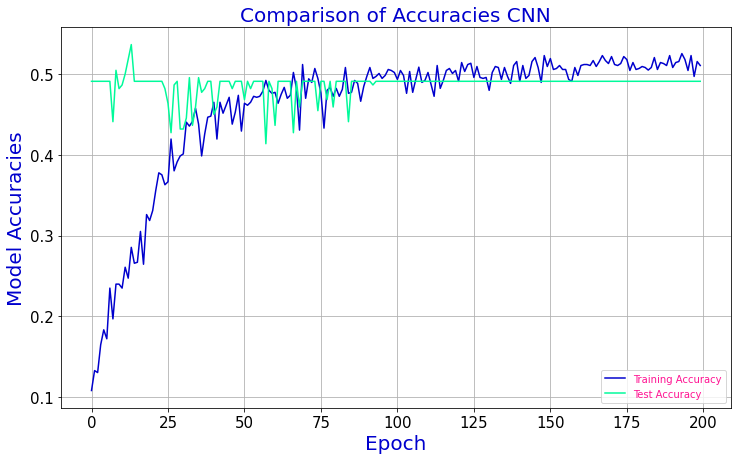

In [ ]:
collist2=["#0000CD","#00FA9A"]
model_stat_cnn.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist2)
plt.title("Comparison of Accuracies CNN",fontsize=20,color=collist2[0])
plt.xlabel("Epoch",fontsize=20,color=collist2[0])
plt.ylabel("Model Accuracies",fontsize=20,color=collist2[0])
plt.grid()
plt.show()

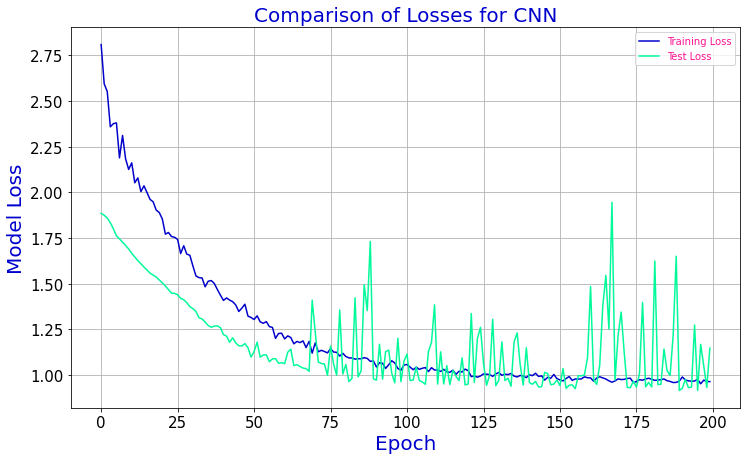

In [ ]:
model_stat_cnn.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist2)
plt.title("Comparison of Losses for CNN",fontsize=20,color=collist2[0])
plt.xlabel("Epoch",fontsize=20,color=collist2[0])
plt.ylabel("Model Loss",fontsize=20,color=collist2[0])
plt.grid()
plt.show()

# Testing Disease Prediction

[2.1503437e-03 9.8889357e-01 2.0766926e-03 1.8787765e-03 9.3790941e-04
 1.8800920e-03 2.1825365e-03]


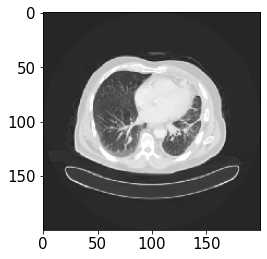

Prediction: Malignant cases


In [ ]:
from skimage import io
from keras.preprocessing import image
img = image.load_img(dir_lung+'/Malignant cases/Malignant case (1).jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img(dir_lung+'/Malignant cases/Malignant case (1).jpg', grayscale=False, target_size=(200, 200))
disease_class = ldis_typ
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = modelden.predict(x)
print(custom[0])
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [ ]:
models=['DenseNet121','ResNet50','CNN2D']
accdf=pd.DataFrame({"Model":models,"Train Accuracy":tracc,"Training Loss":trlss,"Accuracies":allacc,"Precision":allprec,"Recall":allrecall,"F1-Score":allf1})
accdf["Accuracies"]=accdf["Accuracies"]*100
accdf=accdf.sort_values(by="Accuracies",ascending=False)
for i in accdf.columns.tolist()[1:]:
    accout=accdf.sort_values(by=i,ascending=False)
    fig = px.bar(accout, y=i, x="Model",color="Model",text=i,title="Comparison of {}".format(i),height=500,width=700)
    fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="black"
        )
    )
    fig.show()

In [ ]:
accdf

,Model,Train Accuracy,Training Loss,Accuracies,Precision,Recall,F1-Score
0,DenseNet121,0.297,90.9,9100.000000,91.0,91.0,91.0
1,ResNet50,0.678,80.9,8100.000000,83.0,81.0,81.0
2,CNN2D,1.148,49.1,49.090909,24.0,49.0,32.0
